In [ ]:
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# --------------------
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
from keras.callbacks import ReduceLROnPlateau

# --------------------
from pandas import DataFrame as df
# --------------------
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# --------------------
import tarfile
import pickle
import random
import keras
import sys
import gc

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1ghd13FntXJHD0_e-l00ypaR25HyLXwbc

Downloading...
From: https://drive.google.com/u/0/uc?id=1ghd13FntXJHD0_e-l00ypaR25HyLXwbc
To: /content/RML2016.10b.dat
100% 3.50G/3.50G [00:15<00:00, 219MB/s]


In [ ]:
file = open("RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [ ]:
features = {}

In [ ]:
features['raw']        = X[:,0], X[:,1]


In [ ]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))


In [ ]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))


In [ ]:
def extract_features(*arguments):
    
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    
    return np.stack(desired, axis = 1)

##Extracting Features 

In [ ]:
data = extract_features('integral')
labels = np.array(lbl)

In [ ]:
in_shape = data[0].shape
out_shape = tuple([1]) + in_shape

In [ ]:
del features

##Split Data

In [ ]:
np.random.seed(10)

n_examples = labels.shape[0]

r = np.random.choice(range(n_examples), n_examples, replace = False)

train_examples = r[:840000]
test_examples =  r[:360000]

In [ ]:
X_train = data[train_examples]
X_test = data[test_examples]

y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

##Define functions to plot results for each model

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

# Raw features

##CNN

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow import keras


dr = 0.4
dropout = 0.4

# Build model
model_conv = Sequential()
model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
model_conv.add(Conv2D(64, (3,1), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D())
model_conv.add(Conv2D(16, (3,2), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(Flatten())
model_conv.add(Dropout(rate=1-dropout))
model_conv.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model_conv.add(Dense(10, activation='softmax'))



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_conv.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 2, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2, 64)        256       
                                                                 
 batch_normalization (BatchN  (None, 128, 2, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         6160      
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=5, min_lr=0.00001)

histroy= model_conv.fit(X_train, y_train, epochs = 60, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True),rlrp])


Epoch 1/60
780/780 [==============================] - 13s 16ms/step - loss: 1.1284 - accuracy: 0.5324 - val_loss: 1.0866 - val_accuracy: 0.5440 - lr: 1.0000e-04
Epoch 2/60
780/780 [==============================] - 12s 16ms/step - loss: 1.1267 - accuracy: 0.5329 - val_loss: 1.0825 - val_accuracy: 0.5466 - lr: 1.0000e-04
Epoch 3/60
780/780 [==============================] - 12s 16ms/step - loss: 1.1272 - accuracy: 0.5327 - val_loss: 1.1127 - val_accuracy: 0.5347 - lr: 1.0000e-04
Epoch 4/60
780/780 [==============================] - 12s 16ms/step - loss: 1.1272 - accuracy: 0.5325 - val_loss: 1.1015 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 5/60
780/780 [==============================] - 13s 16ms/step - loss: 1.1272 - accuracy: 0.5323 - val_loss: 1.0864 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 6/60
780/780 [==============================] - 12s 16ms/step - loss: 1.1266 - accuracy: 0.5325 - val_loss: 1.0885 - val_accuracy: 0.5436 - lr: 1.0000e-04
Epoch 7/60
780/780 [==============

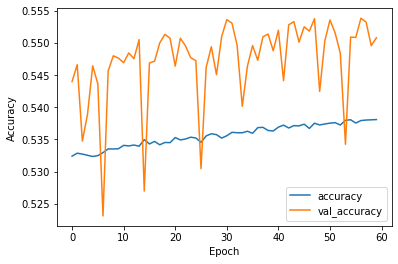

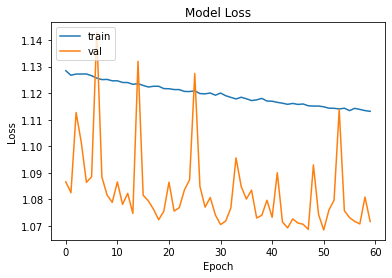

In [ ]:
plt.plot(histroy.history['accuracy'], label='accuracy')
plt.plot(histroy.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
model.save("cnn.h5")


In [ ]:
cnn_model = keras.models.load_model('cnn.h5')


In [ ]:
y_pred_cnn = model_conv.predict(X_test)


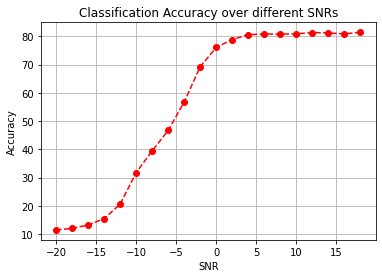

In [ ]:
plot_results(y_pred_cnn, y_test, snr_test)


In [ ]:
print_results(y_pred_cnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,11.47,12.0,13.22,15.47,20.57,31.77,39.46,46.68,56.78,69.24,76.1,78.85,80.61,80.82,80.79,80.88,81.34,81.18,80.86,81.45


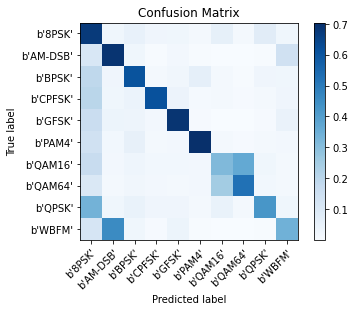

In [ ]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)


##Vanilla RNN

###LR= 0.0001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 10s 9ms/step - loss: 2.1943 - accuracy: 0.1515 - val_loss: 2.1549 - val_accuracy: 0.1611
Epoch 2/80
780/780 [==============================] - 7s 9ms/step - loss: 2.1310 - accuracy: 0.1731 - val_loss: 2.1195 - val_accuracy: 0.1752
Epoch 3/80
780/780 [==============================] - 7s 9ms/step - loss: 2.1147 - accuracy: 0.1763 - val_loss: 2.1112 - val_accuracy: 0.1738
Epoch 4/80
780/780 [==============================] - 7s 9ms/step - loss: 2.1074 - accuracy: 0.1822 - val_loss: 2.1041 - val_accuracy: 0.1856
Epoch 5/80
780/780 [==============================] - 8s 10ms/step - loss: 2.1000 - accuracy: 0.1868 - val_loss: 2.0962 - val_accuracy: 0.1842
Epoch 6/80
780/780 [==============================] - 7s 9ms/step - loss: 2.0922 - accuracy: 0.1902 - val_loss: 2.0883 - val_accuracy: 0.1886
Epoch 7/80
780/780 [==============================] - 7s 9ms/step - loss: 2.0838 - accuracy: 0.1923 - val_loss: 2.0794 - val_accuracy: 0.1901
Epoc

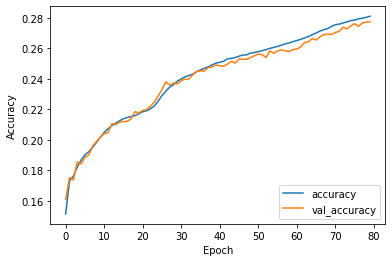

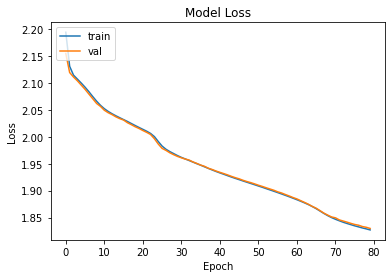

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


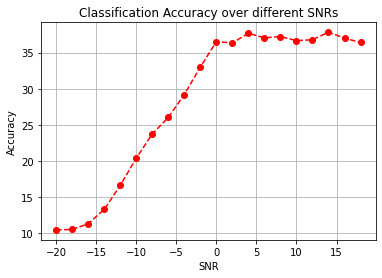

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.46,10.52,11.32,13.3,16.61,20.39,23.73,26.02,29.19,32.99,36.51,36.32,37.67,37.03,37.21,36.64,36.77,37.8,36.99,36.39


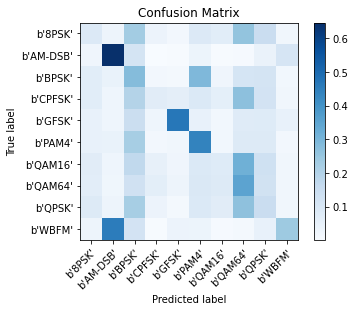

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


###LR= 0.001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3552 - accuracy: 0.4454 - val_loss: 1.3864 - val_accuracy: 0.4361
Epoch 2/80
780/780 [==============================] - 7s 10ms/step - loss: 1.3544 - accuracy: 0.4457 - val_loss: 1.3834 - val_accuracy: 0.4351
Epoch 3/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3521 - accuracy: 0.4469 - val_loss: 1.3838 - val_accuracy: 0.4326
Epoch 4/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3508 - accuracy: 0.4475 - val_loss: 1.3803 - val_accuracy: 0.4370
Epoch 5/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3494 - accuracy: 0.4482 - val_loss: 1.3819 - val_accuracy: 0.4368
Epoch 6/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3482 - accuracy: 0.4484 - val_loss: 1.3799 - val_accuracy: 0.4382
Epoch 7/80
780/780 [==============================] - 7s 9ms/step - loss: 1.3463 - accuracy: 0.4489 - val_loss: 1.3769 - val_accuracy: 0.4374
Epoch

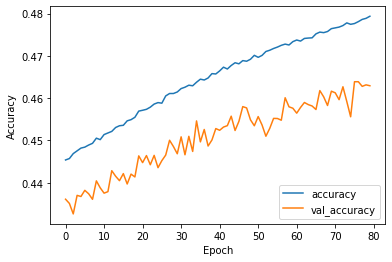

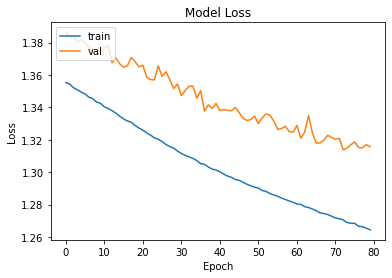

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


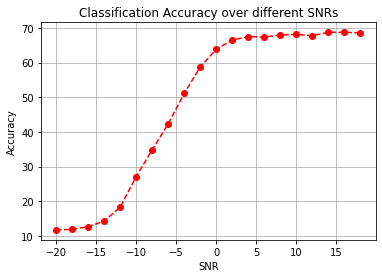

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,11.38,11.86,12.45,14.23,18.72,26.7,33.22,40.41,49.18,56.58,61.54,64.0,64.93,64.78,65.4,64.97,65.43,65.11,65.07,65.14


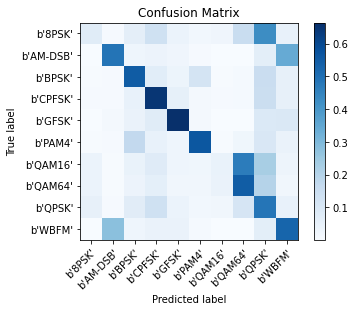

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


##RNN 

### LR = 0.0001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            131584    
                                                                 
 simple_rnn (SimpleRNN)      (None, 2, 128)            32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 100, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/100
780/780 [==============================] - 17s 12ms/step - loss: 2.1836 - accuracy: 0.1563 - val_loss: 2.1322 - val_accuracy: 0.1757
Epoch 2/100
780/780 [==============================] - 9s 11ms/step - loss: 2.1164 - accuracy: 0.1708 - val_loss: 2.1075 - val_accuracy: 0.1681
Epoch 3/100
780/780 [==============================] - 9s 11ms/step - loss: 2.1003 - accuracy: 0.1792 - val_loss: 2.0938 - val_accuracy: 0.1796
Epoch 4/100
780/780 [==============================] - 9s 11ms/step - loss: 2.0863 - accuracy: 0.1873 - val_loss: 2.0769 - val_accuracy: 0.1912
Epoch 5/100
780/780 [==============================] - 9s 11ms/step - loss: 2.0682 - accuracy: 0.1964 - val_loss: 2.0599 - val_accuracy: 0.1997
Epoch 6/100
780/780 [==============================] - 9s 11ms/step - loss: 2.0550 - accuracy: 0.2028 - val_loss: 2.0494 - val_accuracy: 0.2035
Epoch 7/100
780/780 [==============================] - 9s 11ms/step - loss: 2.0455 - accuracy: 0.2080 - val_loss: 2.0407 - val_accuracy

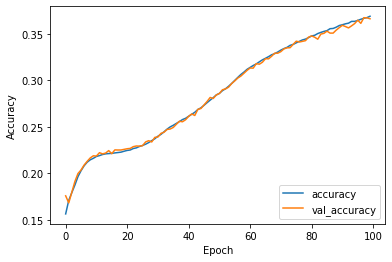

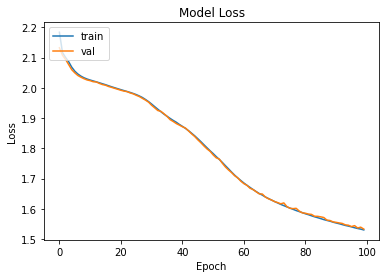

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


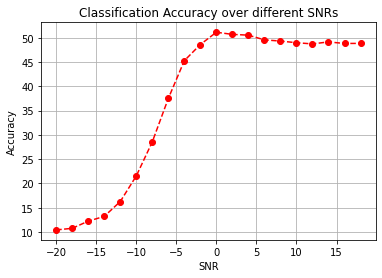

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.43,10.76,12.24,13.22,16.27,21.54,28.56,37.5,45.28,48.61,51.14,50.7,50.54,49.57,49.33,48.98,48.74,49.15,48.83,48.85


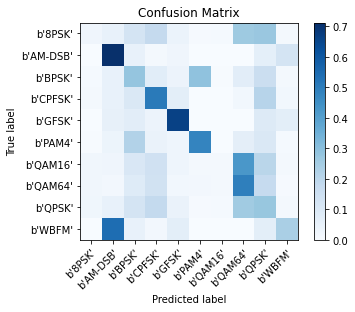

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)


###LR  = 0.001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 128)            131584    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 12s 12ms/step - loss: 2.0932 - accuracy: 0.1827 - val_loss: 2.0399 - val_accuracy: 0.2077
Epoch 2/80
780/780 [==============================] - 9s 11ms/step - loss: 2.0207 - accuracy: 0.2145 - val_loss: 2.0054 - val_accuracy: 0.2172
Epoch 3/80
780/780 [==============================] - 9s 11ms/step - loss: 1.9580 - accuracy: 0.2383 - val_loss: 1.8968 - val_accuracy: 0.2572
Epoch 4/80
780/780 [==============================] - 9s 11ms/step - loss: 1.7913 - accuracy: 0.2902 - val_loss: 1.7237 - val_accuracy: 0.3082
Epoch 5/80
780/780 [==============================] - 9s 11ms/step - loss: 1.6709 - accuracy: 0.3225 - val_loss: 1.6316 - val_accuracy: 0.3322
Epoch 6/80
780/780 [==============================] - 9s 11ms/step - loss: 1.5974 - accuracy: 0.3446 - val_loss: 1.5688 - val_accuracy: 0.3559
Epoch 7/80
780/780 [==============================] - 9s 11ms/step - loss: 1.5455 - accuracy: 0.3633 - val_loss: 1.5285 - val_accuracy: 0.366

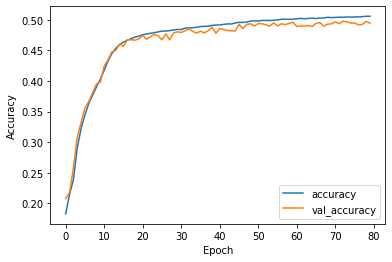

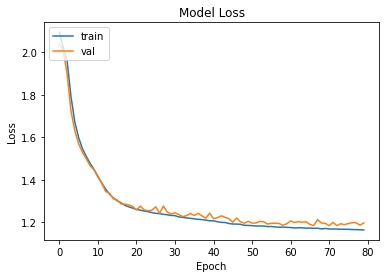

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


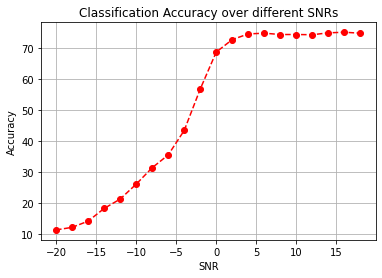

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,11.22,12.05,14.05,18.15,21.18,25.99,31.32,35.44,43.36,56.74,68.71,72.74,74.57,74.81,74.38,74.38,74.31,74.92,75.11,74.8


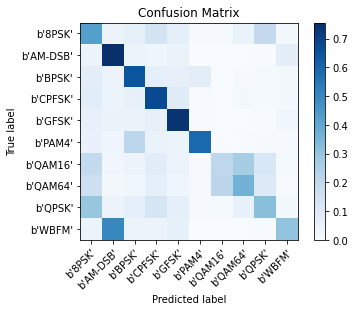

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)


# Derivative features

##CNN

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow import keras


dr = 0.4
dropout = 0.4

# Build model
model_conv = Sequential()
model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
model_conv.add(Conv2D(64, (3,1), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D())
model_conv.add(Conv2D(16, (3,2), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(Flatten())
model_conv.add(Dropout(rate=1-dropout))
model_conv.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model_conv.add(Dense(10, activation='softmax'))



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_conv.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 2, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2, 64)        256       
                                                                 
 batch_normalization (BatchN  (None, 128, 2, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         6160      
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=5, min_lr=0.00001)

histroy= model_conv.fit(X_train, y_train, epochs = 60, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True),rlrp])


Epoch 1/60
780/780 [==============================] - 25s 16ms/step - loss: 2.2533 - accuracy: 0.1640 - val_loss: 2.0769 - val_accuracy: 0.2250 - lr: 1.0000e-04
Epoch 2/60
780/780 [==============================] - 12s 15ms/step - loss: 2.0223 - accuracy: 0.2391 - val_loss: 1.9228 - val_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 3/60
780/780 [==============================] - 12s 15ms/step - loss: 1.9283 - accuracy: 0.2702 - val_loss: 1.8525 - val_accuracy: 0.3019 - lr: 1.0000e-04
Epoch 4/60
780/780 [==============================] - 12s 15ms/step - loss: 1.8733 - accuracy: 0.2898 - val_loss: 1.7952 - val_accuracy: 0.3238 - lr: 1.0000e-04
Epoch 5/60
780/780 [==============================] - 12s 16ms/step - loss: 1.8276 - accuracy: 0.3058 - val_loss: 1.7444 - val_accuracy: 0.3433 - lr: 1.0000e-04
Epoch 6/60
780/780 [==============================] - 12s 16ms/step - loss: 1.7905 - accuracy: 0.3189 - val_loss: 1.7100 - val_accuracy: 0.3548 - lr: 1.0000e-04
Epoch 7/60
780/780 [==============

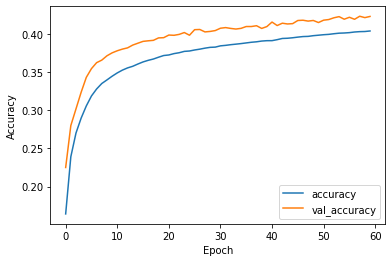

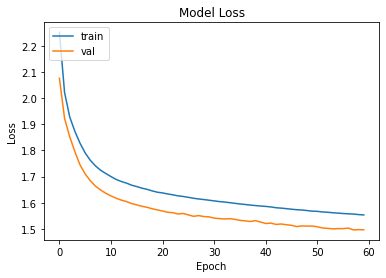

In [ ]:
plt.plot(histroy.history['accuracy'], label='accuracy')
plt.plot(histroy.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_cnn = model_conv.predict(X_test)


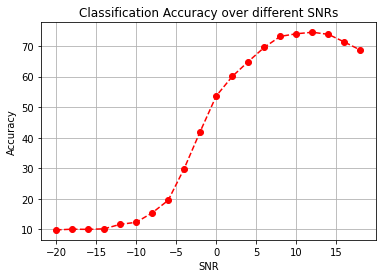

In [ ]:
plot_results(y_pred_cnn, y_test, snr_test)


In [ ]:
print_results(y_pred_cnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.76,10.0,9.94,10.12,11.58,12.26,15.34,19.46,29.88,42.02,53.66,60.06,64.94,69.6,73.2,74.05,74.56,73.86,71.35,68.7


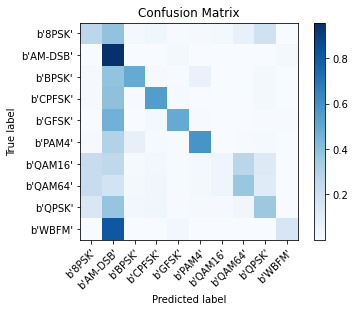

In [ ]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)


##Vanilla RNN

###LR= 0.0001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2, 128)            32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 8s 9ms/step - loss: 2.3084 - accuracy: 0.1037 - val_loss: 2.3043 - val_accuracy: 0.1090
Epoch 2/80
780/780 [==============================] - 7s 9ms/step - loss: 2.3038 - accuracy: 0.1104 - val_loss: 2.3036 - val_accuracy: 0.1137
Epoch 3/80
780/780 [==============================] - 6s 8ms/step - loss: 2.3029 - accuracy: 0.1148 - val_loss: 2.3034 - val_accuracy: 0.1148
Epoch 4/80
780/780 [==============================] - 6s 8ms/step - loss: 2.3025 - accuracy: 0.1179 - val_loss: 2.3032 - val_accuracy: 0.1131
Epoch 5/80
780/780 [==============================] - 6s 8ms/step - loss: 2.3020 - accuracy: 0.1201 - val_loss: 2.3024 - val_accuracy: 0.1171
Epoch 6/80
780/780 [==============================] - 6s 8ms/step - loss: 2.2968 - accuracy: 0.1299 - val_loss: 2.2828 - val_accuracy: 0.1448
Epoch 7/80
780/780 [==============================] - 6s 8ms/step - loss: 2.2366 - accuracy: 0.1600 - val_loss: 2.2028 - val_accuracy: 0.1644
Epoch 

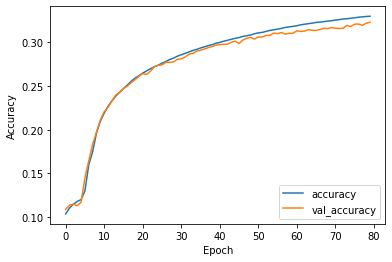

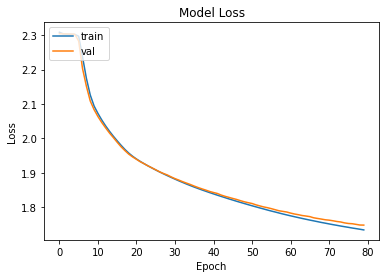

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


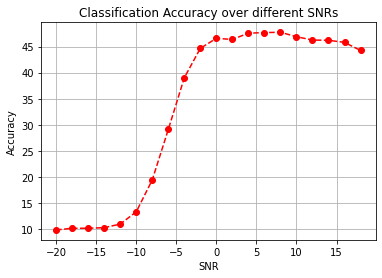

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.83,10.14,10.15,10.27,10.95,13.31,19.43,29.1,39.02,44.66,46.57,46.36,47.56,47.67,47.74,46.88,46.24,46.2,45.79,44.25


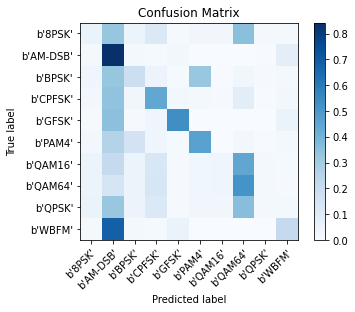

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


###LR= 0.001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 8s 9ms/step - loss: 2.3063 - accuracy: 0.1114 - val_loss: 2.3039 - val_accuracy: 0.1140
Epoch 2/80
780/780 [==============================] - 6s 8ms/step - loss: 2.2407 - accuracy: 0.1434 - val_loss: 2.0961 - val_accuracy: 0.1954
Epoch 3/80
780/780 [==============================] - 6s 8ms/step - loss: 2.0245 - accuracy: 0.2326 - val_loss: 1.9706 - val_accuracy: 0.2494
Epoch 4/80
780/780 [==============================] - 6s 8ms/step - loss: 1.9341 - accuracy: 0.2643 - val_loss: 1.9005 - val_accuracy: 0.2769
Epoch 5/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8742 - accuracy: 0.2859 - val_loss: 1.8509 - val_accuracy: 0.2929
Epoch 6/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8327 - accuracy: 0.2992 - val_loss: 1.8223 - val_accuracy: 0.2975
Epoch 7/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8032 - accuracy: 0.3077 - val_loss: 1.7973 - val_accuracy: 0.3116
Epoch 

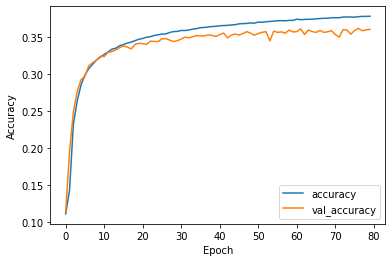

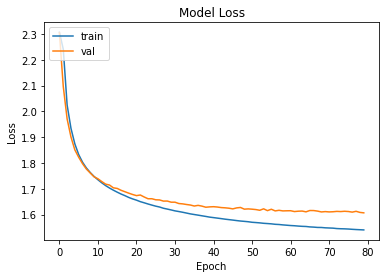

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


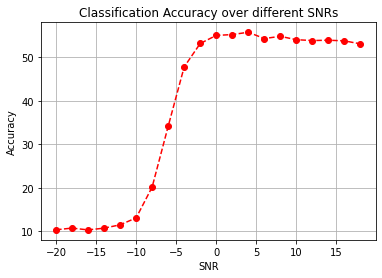

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.36,10.75,10.33,10.74,11.51,13.09,20.2,34.16,47.82,53.2,55.05,55.25,55.78,54.33,54.84,54.07,53.87,53.95,53.8,53.11


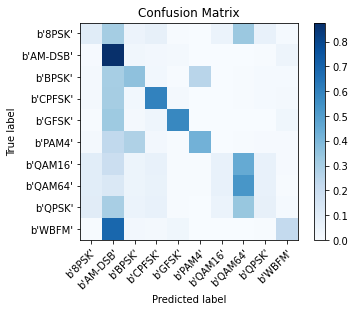

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


##RNN 

### LR = 0.0001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 128)            131584    
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 activation_4 (Activation)   (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 100, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/100
780/780 [==============================] - 11s 11ms/step - loss: 2.2565 - accuracy: 0.1317 - val_loss: 2.1251 - val_accuracy: 0.1816
Epoch 2/100
780/780 [==============================] - 8s 11ms/step - loss: 2.1072 - accuracy: 0.1849 - val_loss: 2.0975 - val_accuracy: 0.1893
Epoch 3/100
780/780 [==============================] - 8s 11ms/step - loss: 2.0773 - accuracy: 0.2028 - val_loss: 2.0325 - val_accuracy: 0.2240
Epoch 4/100
780/780 [==============================] - 8s 10ms/step - loss: 2.0066 - accuracy: 0.2399 - val_loss: 1.9906 - val_accuracy: 0.2430
Epoch 5/100
780/780 [==============================] - 8s 11ms/step - loss: 1.9800 - accuracy: 0.2521 - val_loss: 1.9691 - val_accuracy: 0.2540
Epoch 6/100
780/780 [==============================] - 8s 11ms/step - loss: 1.9595 - accuracy: 0.2614 - val_loss: 1.9506 - val_accuracy: 0.2668
Epoch 7/100
780/780 [==============================] - 8s 10ms/step - loss: 1.9441 - accuracy: 0.2678 - val_loss: 1.9399 - val_accuracy

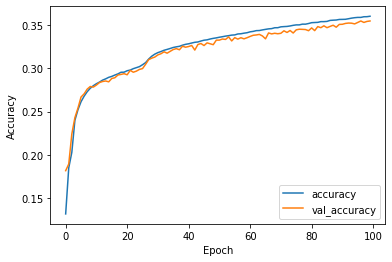

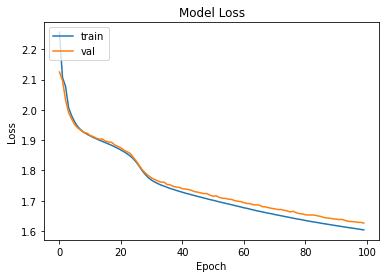

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


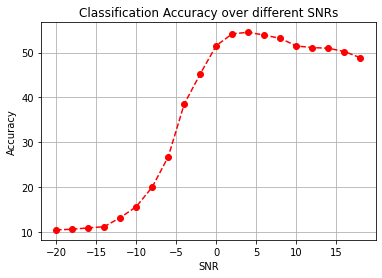

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.48,10.63,10.92,11.19,13.19,15.63,20.0,26.73,38.49,45.23,51.54,54.15,54.51,53.87,53.15,51.46,51.1,50.95,50.21,48.83


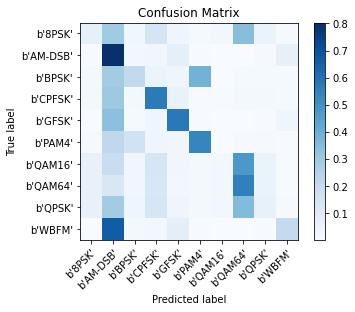

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)


###LR  = 0.001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 128)            131584    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 100, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/100
780/780 [==============================] - 12s 12ms/step - loss: 2.0338 - accuracy: 0.2270 - val_loss: 1.9225 - val_accuracy: 0.2714
Epoch 2/100
780/780 [==============================] - 9s 12ms/step - loss: 1.8336 - accuracy: 0.3018 - val_loss: 1.7477 - val_accuracy: 0.3210
Epoch 3/100
780/780 [==============================] - 9s 12ms/step - loss: 1.7182 - accuracy: 0.3300 - val_loss: 1.6981 - val_accuracy: 0.3366
Epoch 4/100
780/780 [==============================] - 9s 11ms/step - loss: 1.6660 - accuracy: 0.3434 - val_loss: 1.6499 - val_accuracy: 0.3508
Epoch 5/100
780/780 [==============================] - 11s 14ms/step - loss: 1.6218 - accuracy: 0.3544 - val_loss: 1.6124 - val_accuracy: 0.3584
Epoch 6/100
780/780 [==============================] - 9s 11ms/step - loss: 1.5936 - accuracy: 0.3613 - val_loss: 1.5908 - val_accuracy: 0.3618
Epoch 7/100
780/780 [==============================] - 9s 11ms/step - loss: 1.5768 - accuracy: 0.3662 - val_loss: 1.5800 - val_accurac

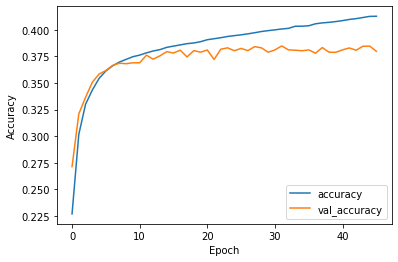

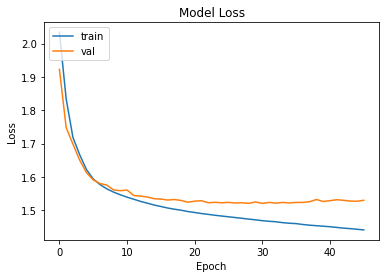

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


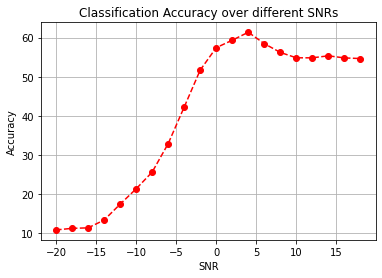

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.9,11.3,11.43,13.41,17.47,21.38,25.66,32.92,42.26,51.7,57.42,59.32,61.36,58.45,56.21,54.83,54.83,55.34,54.8,54.64


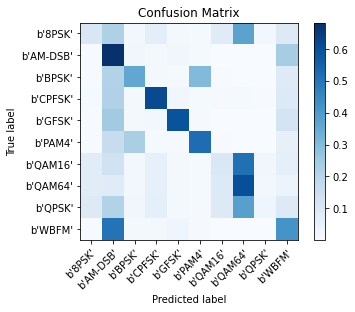

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)


# Integral features

##CNN

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow import keras


dr = 0.4
dropout = 0.4

# Build model
model_conv = Sequential()
model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
model_conv.add(Conv2D(64, (3,1), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D())
model_conv.add(Conv2D(16, (3,2), strides=1,
                padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
model_conv.add(Flatten())
model_conv.add(Dropout(rate=1-dropout))
model_conv.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model_conv.add(Dense(10, activation='softmax'))



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_conv.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 2, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2, 64)        256       
                                                                 
 batch_normalization (BatchN  (None, 128, 2, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         6160      
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=5, min_lr=0.00001)

histroy= model_conv.fit(X_train, y_train, epochs = 60, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True),rlrp])


Epoch 1/60
780/780 [==============================] - 25s 16ms/step - loss: 2.1612 - accuracy: 0.1824 - val_loss: 1.9824 - val_accuracy: 0.2258 - lr: 1.0000e-04
Epoch 2/60
780/780 [==============================] - 12s 15ms/step - loss: 1.9230 - accuracy: 0.2413 - val_loss: 1.8384 - val_accuracy: 0.2686 - lr: 1.0000e-04
Epoch 3/60
780/780 [==============================] - 12s 16ms/step - loss: 1.8301 - accuracy: 0.2732 - val_loss: 1.7600 - val_accuracy: 0.3054 - lr: 1.0000e-04
Epoch 4/60
780/780 [==============================] - 12s 15ms/step - loss: 1.7656 - accuracy: 0.2987 - val_loss: 1.6927 - val_accuracy: 0.3257 - lr: 1.0000e-04
Epoch 5/60
780/780 [==============================] - 12s 16ms/step - loss: 1.7144 - accuracy: 0.3179 - val_loss: 1.6415 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 6/60
780/780 [==============================] - 12s 16ms/step - loss: 1.6776 - accuracy: 0.3309 - val_loss: 1.6070 - val_accuracy: 0.3585 - lr: 1.0000e-04
Epoch 7/60
780/780 [==============

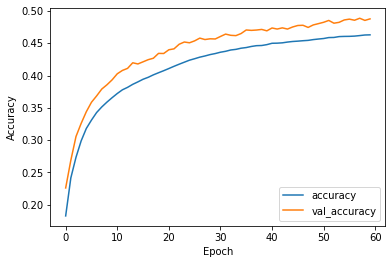

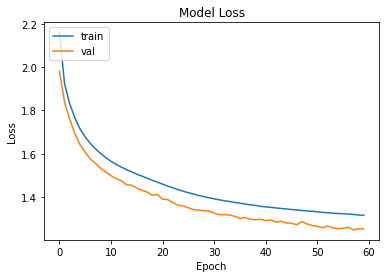

In [ ]:
plt.plot(histroy.history['accuracy'], label='accuracy')
plt.plot(histroy.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_cnn = model_conv.predict(X_test)


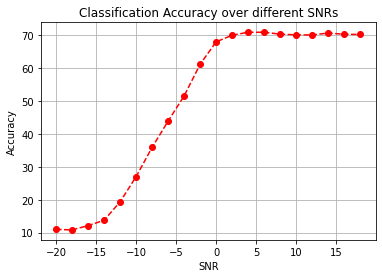

In [ ]:
plot_results(y_pred_cnn, y_test, snr_test)


In [ ]:
print_results(y_pred_cnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.97,10.8,12.11,13.73,19.35,27.01,35.92,43.91,51.58,61.2,67.99,70.0,70.89,70.88,70.31,70.09,70.06,70.65,70.26,70.21


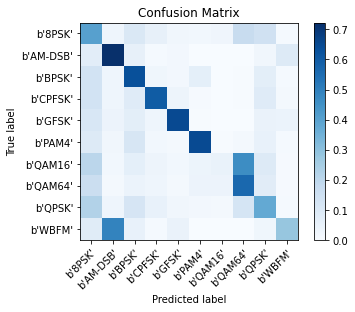

In [ ]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)


##Vanilla RNN

###LR= 0.0001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2, 128)            32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 8s 9ms/step - loss: 2.2353 - accuracy: 0.1454 - val_loss: 2.2315 - val_accuracy: 0.1485
Epoch 2/80
780/780 [==============================] - 6s 8ms/step - loss: 2.2249 - accuracy: 0.1515 - val_loss: 2.2200 - val_accuracy: 0.1540
Epoch 3/80
780/780 [==============================] - 6s 8ms/step - loss: 2.1957 - accuracy: 0.1625 - val_loss: 2.1745 - val_accuracy: 0.1636
Epoch 4/80
780/780 [==============================] - 6s 8ms/step - loss: 2.1492 - accuracy: 0.1753 - val_loss: 2.1324 - val_accuracy: 0.1844
Epoch 5/80
780/780 [==============================] - 7s 8ms/step - loss: 2.1134 - accuracy: 0.1901 - val_loss: 2.1039 - val_accuracy: 0.1923
Epoch 6/80
780/780 [==============================] - 6s 8ms/step - loss: 2.0887 - accuracy: 0.1994 - val_loss: 2.0831 - val_accuracy: 0.2032
Epoch 7/80
780/780 [==============================] - 6s 8ms/step - loss: 2.0709 - accuracy: 0.2068 - val_loss: 2.0689 - val_accuracy: 0.2085
Epoch 

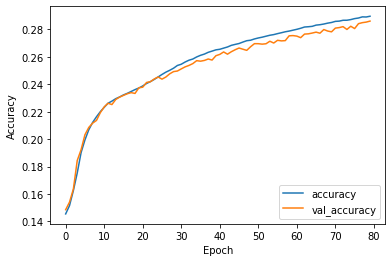

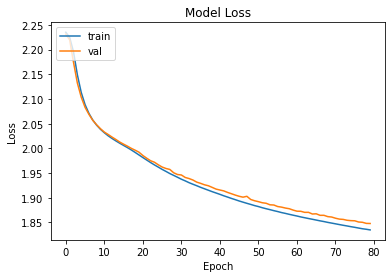

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


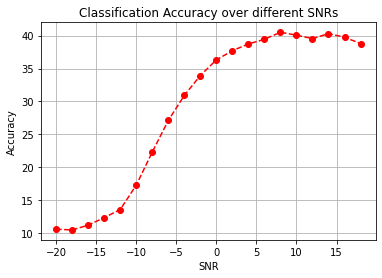

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.6,10.49,11.22,12.36,13.59,17.3,22.33,27.12,30.91,33.94,36.31,37.7,38.73,39.43,40.51,40.06,39.54,40.29,39.75,38.79


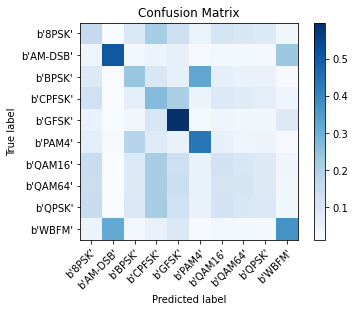

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


###LR= 0.001

In [ ]:

import numpy as np

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 67,082
Trainable params: 67,082
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 8s 9ms/step - loss: 2.1889 - accuracy: 0.1611 - val_loss: 2.1091 - val_accuracy: 0.1946
Epoch 2/80
780/780 [==============================] - 6s 8ms/step - loss: 2.0522 - accuracy: 0.2123 - val_loss: 2.0145 - val_accuracy: 0.2263
Epoch 3/80
780/780 [==============================] - 6s 8ms/step - loss: 1.9776 - accuracy: 0.2413 - val_loss: 1.9725 - val_accuracy: 0.2467
Epoch 4/80
780/780 [==============================] - 7s 9ms/step - loss: 1.9294 - accuracy: 0.2588 - val_loss: 1.9248 - val_accuracy: 0.2624
Epoch 5/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8982 - accuracy: 0.2694 - val_loss: 1.8928 - val_accuracy: 0.2726
Epoch 6/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8738 - accuracy: 0.2780 - val_loss: 1.8764 - val_accuracy: 0.2775
Epoch 7/80
780/780 [==============================] - 6s 8ms/step - loss: 1.8539 - accuracy: 0.2852 - val_loss: 1.8561 - val_accuracy: 0.2817
Epoch 

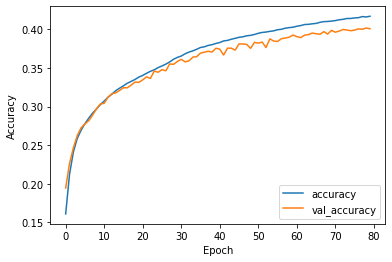

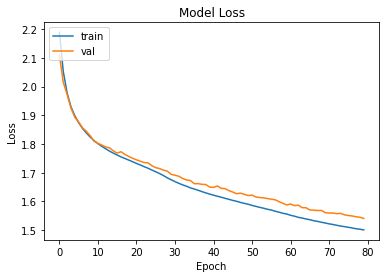

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn = model.predict(X_test)


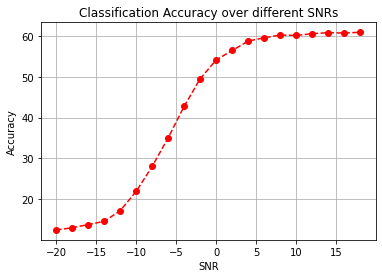

In [ ]:
plot_results(y_pred_rnn, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,12.45,12.96,13.76,14.54,17.14,21.89,28.01,35.05,42.79,49.55,54.16,56.46,58.78,59.58,60.26,60.15,60.59,60.83,60.74,60.94


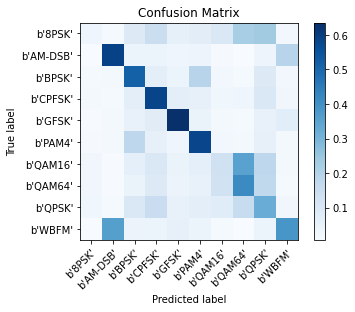

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn, mods)


##RNN 

### LR = 0.0001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            131584    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 100, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/100
780/780 [==============================] - 14s 13ms/step - loss: 2.1944 - accuracy: 0.1586 - val_loss: 2.1558 - val_accuracy: 0.1680
Epoch 2/100
780/780 [==============================] - 9s 11ms/step - loss: 2.1378 - accuracy: 0.1819 - val_loss: 2.1340 - val_accuracy: 0.1872
Epoch 3/100
780/780 [==============================] - 9s 12ms/step - loss: 2.1217 - accuracy: 0.1982 - val_loss: 2.1217 - val_accuracy: 0.1973
Epoch 4/100
780/780 [==============================] - 9s 12ms/step - loss: 2.1040 - accuracy: 0.2080 - val_loss: 2.0950 - val_accuracy: 0.2095
Epoch 5/100
780/780 [==============================] - 9s 12ms/step - loss: 2.0732 - accuracy: 0.2183 - val_loss: 2.0640 - val_accuracy: 0.2152
Epoch 6/100
780/780 [==============================] - 8s 10ms/step - loss: 2.0467 - accuracy: 0.2249 - val_loss: 2.0422 - val_accuracy: 0.2236
Epoch 7/100
780/780 [==============================] - 8s 11ms/step - loss: 2.0281 - accuracy: 0.2291 - val_loss: 2.0253 - val_accuracy

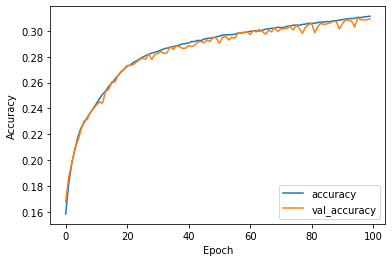

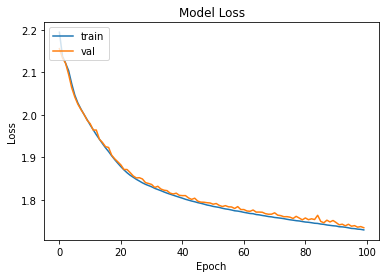

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


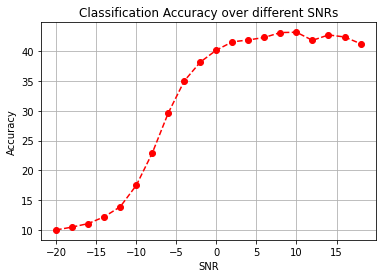

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.05,10.52,11.11,12.25,13.92,17.5,22.91,29.63,34.98,38.13,40.13,41.52,41.83,42.26,43.07,43.13,41.77,42.68,42.33,41.21


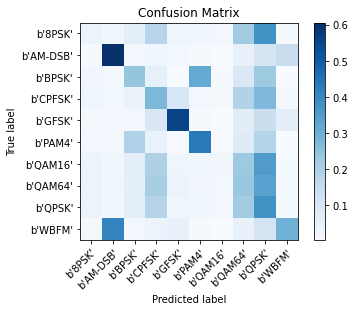

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)


###LR  = 0.001

In [ ]:

import numpy as np
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf 
model = Sequential()
model.add(layers.LSTM(128,input_shape = in_shape,return_sequences = True))
model.add(SimpleRNN(128, input_shape = in_shape, return_sequences = True))
model.add(SimpleRNN(128, input_shape =in_shape, return_sequences = False))

model.add(Dense(10))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.build(in_shape) # `input_shape` is the shape of the input data

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 128)            131584    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 2, 128)            32896     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Epoch 1/80
780/780 [==============================] - 12s 12ms/step - loss: 2.1005 - accuracy: 0.2009 - val_loss: 2.0154 - val_accuracy: 0.2300
Epoch 2/80
780/780 [==============================] - 8s 10ms/step - loss: 1.9294 - accuracy: 0.2560 - val_loss: 1.8872 - val_accuracy: 0.2669
Epoch 3/80
780/780 [==============================] - 8s 10ms/step - loss: 1.8529 - accuracy: 0.2772 - val_loss: 1.8406 - val_accuracy: 0.2820
Epoch 4/80
780/780 [==============================] - 8s 10ms/step - loss: 1.8128 - accuracy: 0.2877 - val_loss: 1.8148 - val_accuracy: 0.2885
Epoch 5/80
780/780 [==============================] - 8s 10ms/step - loss: 1.7862 - accuracy: 0.2939 - val_loss: 1.7972 - val_accuracy: 0.2947
Epoch 6/80
780/780 [==============================] - 8s 10ms/step - loss: 1.7678 - accuracy: 0.2989 - val_loss: 1.7791 - val_accuracy: 0.2953
Epoch 7/80
780/780 [==============================] - 8s 11ms/step - loss: 1.7511 - accuracy: 0.3044 - val_loss: 1.7537 - val_accuracy: 0.307

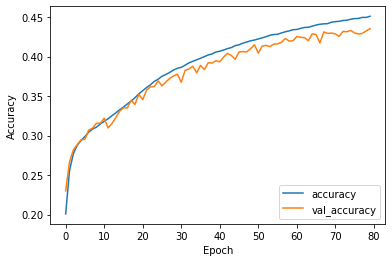

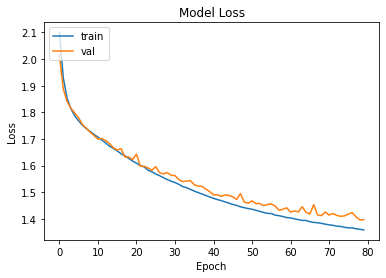

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
y_pred_rnn_lstm= model.predict(X_test)


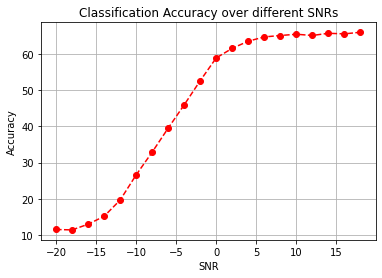

In [ ]:
plot_results(y_pred_rnn_lstm, y_test, snr_test)


In [ ]:
print_results(y_pred_rnn_lstm, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,11.54,11.42,12.99,15.17,19.65,26.6,32.89,39.52,45.95,52.62,58.91,61.56,63.53,64.71,65.1,65.45,65.11,65.71,65.55,66.0


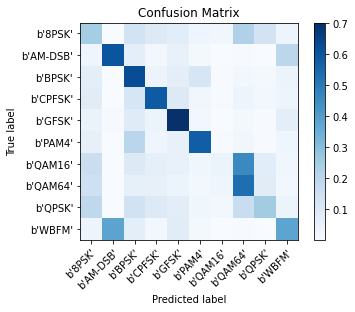

In [ ]:
plot_confusion_matrix(y_test, y_pred_rnn_lstm, mods)
